# Best Grades 
#### Project by Ran Benayoun

## Project Description

This project scrapes the histogram database from Cheesefork's GitHub repository.

It enables analysis of:
- The **average median grade** for each course
- The **maximum grade** recorded in each course

## Limitations

- The statistics are based only on **available histograms**. Courses with no histograms (typically those with under 10 students or no shared data) are **not included** in the analysis.
- **Course numbers change occasionally**, which can result in data loss or duplication.
- In **2024**, the Technion changed course numbers from 6 digits to 7 or 8 digits. This created inconsistencies in the dataset.


In [ ]:
# All the imports needed for the script to function properly
import re
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from time import sleep
import csv
import ipywidgets as widgets
from IPython.display import display

In [ ]:
#Defing functions needed for the script

def find_6_digit_sequences(input_string):
    """
    for catalogs older than 2024
    Finds all unique 6-digit sequences in a given string.

    Args:
        input_string (str): The string to search for 6-digit sequences.

    Returns:
        list: A list of unique 6-digit sequences found in the input string.
    """
    # Define the regex pattern to match 6-digit sequences
    pattern = r'\b\d{6}\b'
    
    # Find all matches using findall() method
    sequences = re.findall(pattern, input_string)
    
    return sequences

def find_7_digit_sequences(input_string):
    """
    for catalogs newer than 2024
    Finds all unique 7-digit sequences in a given string.

    Args:
        input_string (str): The string to search for 76-digit sequences.

    Returns:
        list: A list of unique 7-digit sequences found in the input string.
    """
    # Define the regex pattern to match 7-digit sequences
    pattern = r'\b\d{7}\b'
    
    # Find all matches using findall() method
    sequences = re.findall(pattern, input_string)
    
    return sequences

def clean_string(input_string):
    """
    Cleans a string by removing double quotes, single quotes, new lines, 
    carriage returns, and excessive spaces.

    Args:
        input_string (str): The string to be cleaned.

    Returns:
        str: The cleaned string.
    """
    # Replace unwanted characters
    cleaned_string = input_string.replace('"', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    
    # Remove leading and trailing whitespace
    cleaned_string = cleaned_string.strip()
    
    # Remove excessive spaces between words
    cleaned_string = ' '.join(cleaned_string.split())
    
    return cleaned_string

def load_catalog_file(filename):
    """
    Loads a JSON file and returns the catalog data as a dictionary.

    Args:
        filename (str): The name of the JSON file to be loaded.

    Returns:
        dict: A dictionary containing the catalog data.
    """
    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            catalogs = json.load(f)
        return catalogs
    else:
        print(f"File '{filename}' not found.")
        return {}

def plot_bar_chart_with_trendline(average_medians, save_path=None):
    """
    Plots a bar chart of the average medians with a trendline.
    
    Args:
        average_medians (dict): Dictionary with course numbers as keys and average median values as values.
        save_path (str, optional): If provided, saves the figure to the given path.
    """
    # Filter out None values
    courses = [course for course, median in average_medians.items() if median is not None]
    medians = [median for median in average_medians.values() if median is not None]

    plt.figure(figsize=(10, 6))
    plt.bar(courses, medians, color='skyblue', label='Average Median')

    # Add trendline
    x = np.arange(len(courses))
    z = np.polyfit(x, medians, 1)
    p = np.poly1d(z)
    plt.plot(courses, p(x), "r--", label='Trendline')

    plt.title('Bar Plot of Average Medians by Course Number')
    plt.xlabel('Course Number')
    plt.ylabel('Average Median')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")

    plt.show()

Adding catalog entries with points through the scripts:

In [ ]:
def add_to_catalog_file(filename):
    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            existing_catalogs = json.load(f)
    else:
        existing_catalogs = {}

    # Catalog name input
    catalog_name_widget = widgets.Text(description='Catalog name:')
    display(catalog_name_widget)

    # Textarea for multiline input
    text_area = widgets.Textarea(
        value='',
        placeholder='Paste course data here...',
        description='Courses:',
        layout=widgets.Layout(width='100%', height='300px')
    )
    display(text_area)

    # Button to process and save
    save_button = widgets.Button(description="Save Catalog")
    output = widgets.Output()
    display(save_button, output)

    def on_button_click(b):
        catalog_name = catalog_name_widget.value.strip()
        input_text = text_area.value
        lines = input_text.strip().split('\n')

        current_catalog_data = {}
        for line in lines:
            line = line.strip()
            if not line:
                continue
            match = re.search(r'(\d+).*?(\d+\.\d+)$', line)
            if match:
                course_number = '0' + match.group(1)
                try:
                    points = float(match.group(2))
                    current_catalog_data[course_number] = points
                except ValueError:
                    print(f"Warning: Could not parse points in: '{line}'")
            else:
                print(f"Warning: Format not recognized: '{line}'")

        existing_catalogs[catalog_name] = current_catalog_data

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(existing_catalogs, f, indent=4, ensure_ascii=False)

        with output:
            output.clear_output()
            print(f"Catalog '{catalog_name}' saved to {filename}")
            print(current_catalog_data)

    save_button.on_click(on_button_click)

add_to_catalog_file("Catalogs_points.json")

Text(value='', description='Catalog name:')

Textarea(value='', description='Courses:', layout=Layout(height='300px', width='100%'), placeholder='Paste cou…

Button(description='Save Catalog', style=ButtonStyle())

Output()

This code goes through the list of courses and extract all the stats from Cheesfork's GitHub while showing a progress bar - got to be patient

In [ ]:
def get_finals_statistics(course_numbers, access_token):
    """
    Fetches the finals statistics for the given course numbers from GitHub.

    Args:
        course_numbers (list of str): List of course numbers to fetch statistics for.
        access_token (str): GitHub access token for authentication.

    Returns:
        dict: A dictionary containing the statistics for each course.
    """
    base_url = "https://api.github.com/repos/michael-maltsev/technion-histograms/contents/"
    headers = {'Authorization': f'token {access_token}'}
    all_statistics = {}

    for course_number in tqdm(course_numbers):
        course_url = f"{base_url}{course_number}?ref=main"
        try:
            response = requests.get(course_url, headers=headers)
            response.raise_for_status()
            contents = response.json()

            course_data = {'folders': {}}

            for item in contents:
                if item['type'] == 'dir':
                    folder_name = item['name']
                    finals_json_url = f"https://raw.githubusercontent.com/michael-maltsev/technion-histograms/main/{course_number}/{folder_name}/Finals.json"
                    finals_response = requests.head(finals_json_url)
                    if finals_response.status_code == 200:
                        finals_data = requests.get(finals_json_url).json()
                        course_data['folders'][folder_name] = {
                            'average': finals_data.get('average'),
                            'median': finals_data.get('median')
                        }

            all_statistics[course_number] = course_data
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for course {course_number}: {e}")
        sleep(0.2)
    return all_statistics

def write_to_csv(statistics):
    """
    Writes the finals statistics to a CSV file.

    Args:
        statistics (dict): The statistics data to write to the CSV.
        filename (str): The name of the CSV file to write to.
    """
    filename = input("Enter the filename to save the CSV: ")
    filename = filename + ".csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Course Number', 'Semester', 'Average', 'Median'])
        for course_number, data in statistics.items():
            for folder, stats in data['folders'].items():
                writer.writerow([course_number, folder, stats['average'], stats['median']])
        writer.writerow(['Course Number', 'Average of Medians'])
        #calculate average of medians to put at the end of the CSV
        average_medians = calculate_average_median(statistics)
        for course_number in average_medians:
            writer.writerow([course_number, average_medians[course_number]])
    print(f"Data has been written to {filename}")

def calculate_average_median(statistics):
    """
    Calculates the average of the median values for each course.

    Args:
        statistics (dict): The statistics data containing median values.

    Returns:
        dict: A dictionary with course numbers as keys and their average median values as values.
    """
    average_medians = {}
    for course_number, data in statistics.items():
        medians = []
        for folder in data['folders'].values():
            median_value = folder['median']
            if median_value is not None:
                try:
                    median_value = round(float(median_value), 2)  # Round to 2 decimal places
                    medians.append(median_value)
                except ValueError:
                    # Skip non-numeric median values silently
                    continue
        
        if medians:
            average_median = round(sum(medians) / len(medians), 2)  # Round to 2 decimal places
        else:
            average_median = None
        average_medians[course_number] = average_median

    return average_medians

def calculate_gpa_from_medians(average_medians, catalog_file, catalog_name):
    """
    Calculates GPA using average medians and course credit points.

    Args:
        average_medians (dict): Dictionary with course numbers as keys and average median values.
        catalog_file (str): Path to Catalogs_points.json.
        catalog_name (str): Name of the catalog to use from the file.

    Returns:
        float: Calculated GPA rounded to 2 decimal places.
    """
    try:
        with open(catalog_file, 'r', encoding='utf-8') as f:
            catalogs = json.load(f)
    except (IOError, json.JSONDecodeError) as e:
        print(f"Error reading catalog file: {e}")
        return None

    if catalog_name not in catalogs:
        print(f"Catalog '{catalog_name}' not found in {catalog_file}")
        return None

    catalog_points = catalogs[catalog_name]

    total_weighted = 0.0
    total_points = 0.0

    for course_number, average_median in average_medians.items():
        if average_median is None:
            continue
        if course_number not in catalog_points:
            continue
        points = catalog_points[course_number]
        total_weighted += average_median * points
        total_points += points

    if total_points == 0:
        print("No valid course points found for GPA calculation.")
        return None

    gpa = round(total_weighted / total_points, 2)
    return gpa


Set up your personal access token from GitHub - this next code will test if it's valid. if not you'll be limited to get 60 courses per hour

In [ ]:
access_token = ''  # Replace with your actual access token

# Test the token validity by making a simple API request
test_url = "https://api.github.com/user"
test_response = requests.get(test_url, headers={'Authorization': f'token {access_token}'})

if test_response.status_code == 200:
    print("Token is valid.")
else:
    print(f"Invalid token. Status code: {test_response.status_code}")
    print(test_response.json())

Token is valid.


In [ ]:
catalog = load_catalog_file("Catalogs_points.json")


### Starting with Sports and Malag Courses

In [240]:
sports_courses = catalog["sports"].keys()
sports = calculate_average_median(get_finals_statistics(list(sports_courses), access_token))
print("Sports courses average medians:", sports)
print(f"the best course average grade is:", max(list(sports.values())))

100%|██████████| 9/9 [00:34<00:00,  3.84s/it]

Sports courses average medians: {'03940807': 96.33, '03940802': 94.4, '03940803': 94.6, '03940804': 94.58, '03940806': 95.0, '03940805': 96.4, '03940820': 95.74, '03940801': 94.62, '03940808': 94.25}
the best course average grade is: 96.4


In [241]:
malag_courses = catalog["malag_winter_2026"].keys()
malag_stats = get_finals_statistics(list(malag_courses), access_token)
malag = calculate_average_median(malag_stats)
print("Malag courses average medians:", malag)
print(f"the best course average grade is:", max(list(malag.values())))

100%|██████████| 17/17 [00:35<00:00,  2.08s/it]

Malag courses average medians: {'03240284': 95.14, '03240298': 99.33, '03240307': 94.92, '03240432': 98.55, '03240439': 93.75, '03240442': 93.12, '03240445': 95.58, '03240454': 95.5, '03240474': 97.5, '03240518': 95.75, '03240521': 93.5, '03240527': 94.83, '03240528': 95.0, '03240536': 93.5, '03250011': 96.0, '03250010': 93.67, '03260009': 96.75}
the best course average grade is: 99.33


Based on the data, you'd think it's the best malag to take - but it doesn't tell the whole story. recent trends in Malag's grades are shifting, and grades are getting lower.

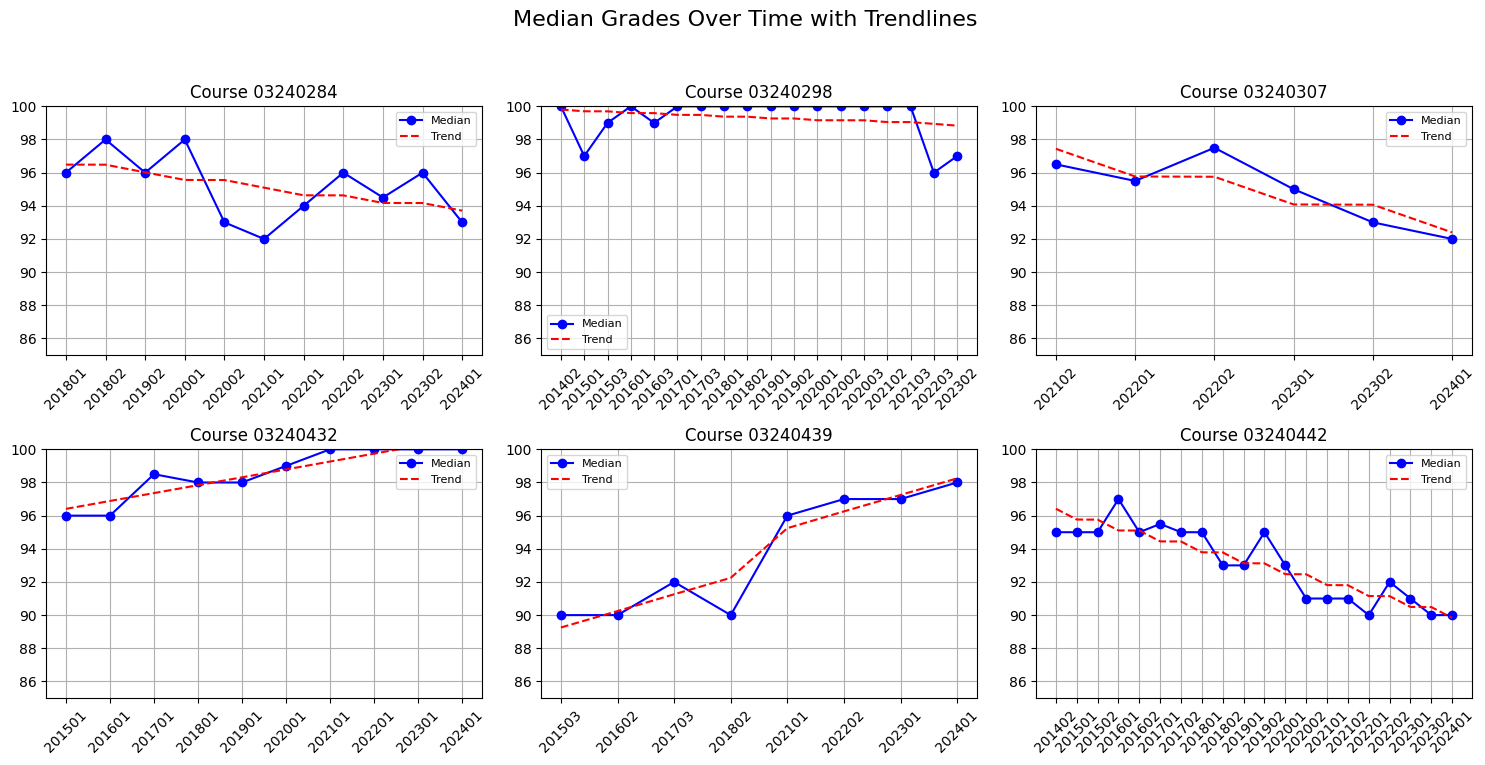

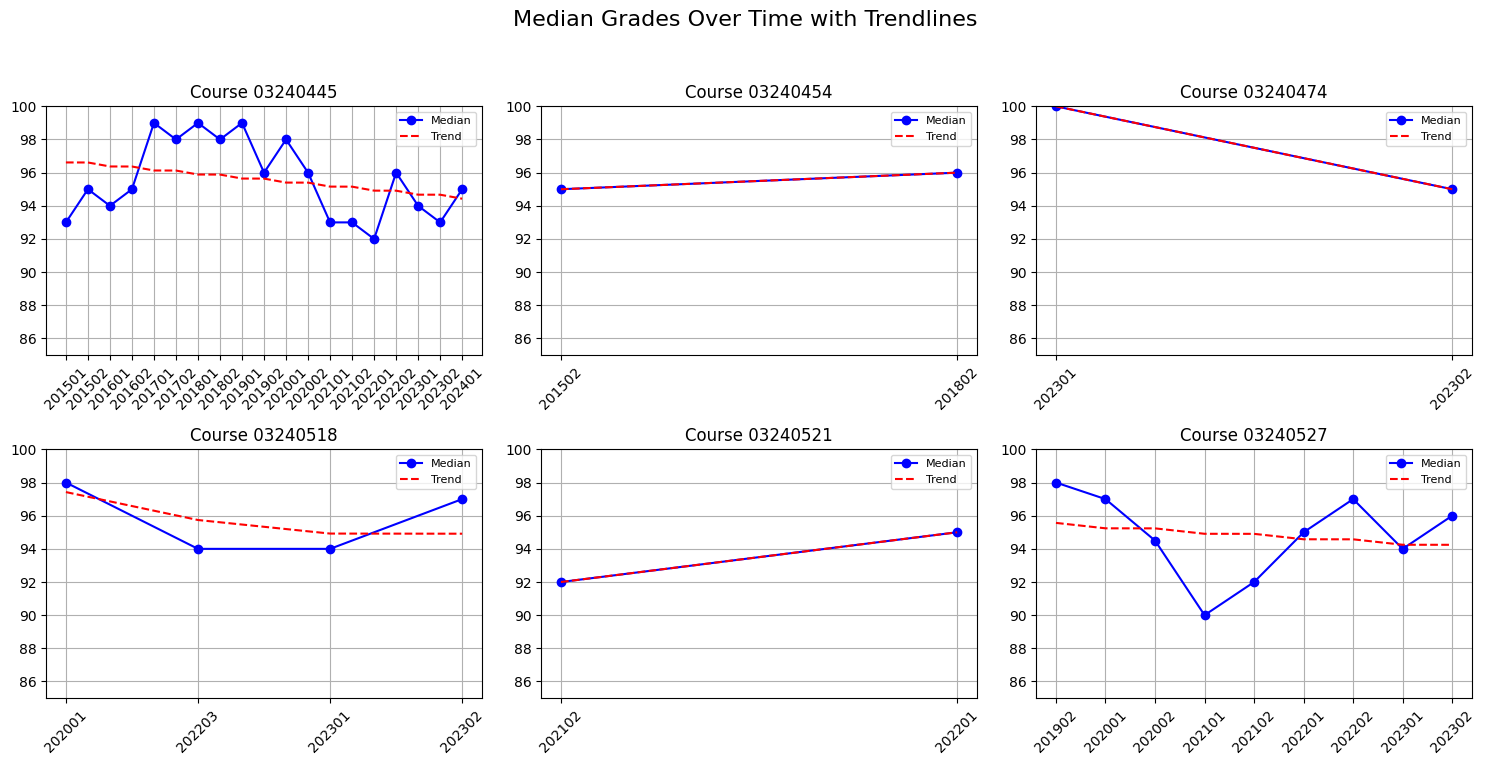

/tmp/ipykernel_1691/2102195517.py:43: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 1)


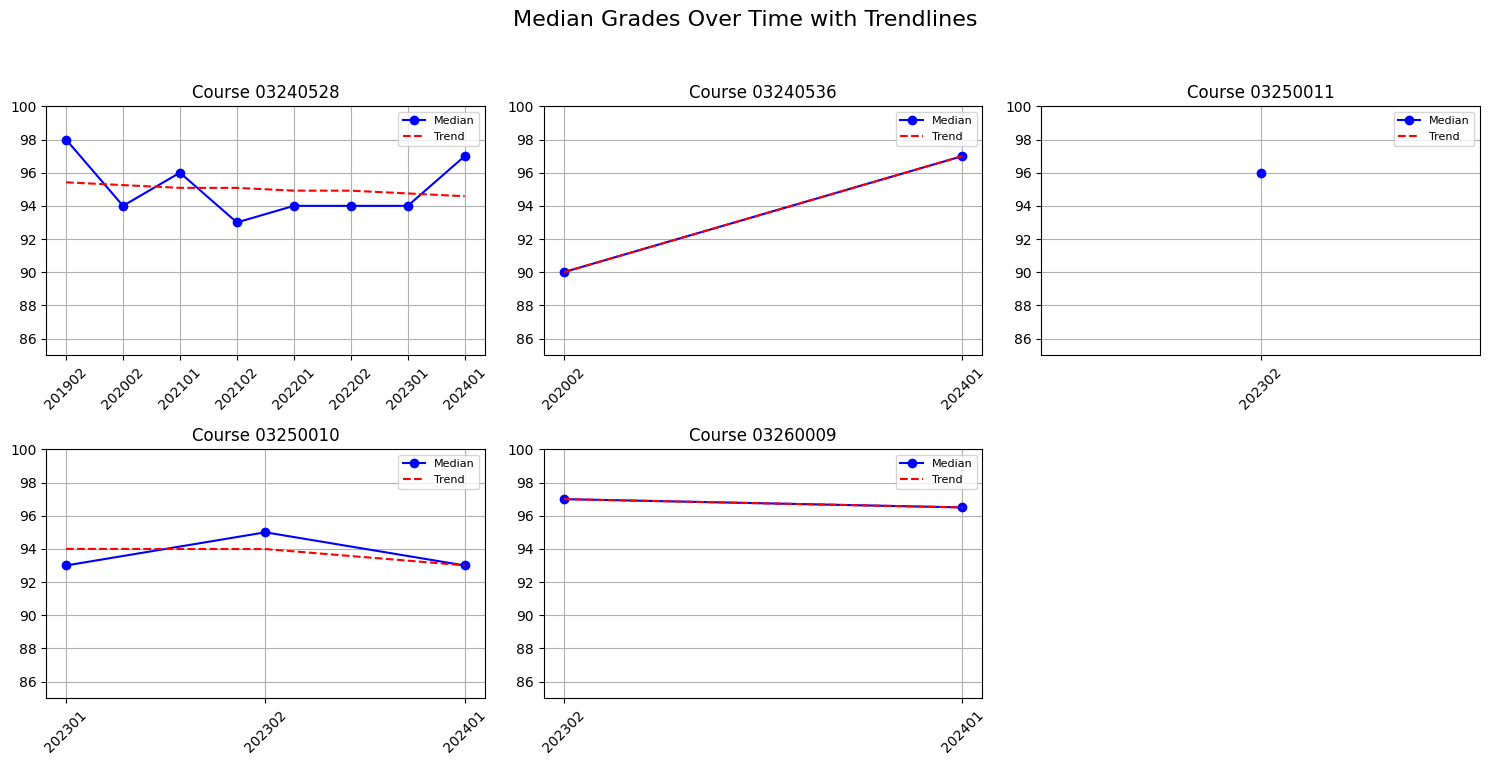

In [255]:
#plot the median over time
import matplotlib.pyplot as plt
import numpy as np

def plot_median_grades(statistics, per_figure=6):
    """
    Plots median grades with trendlines using subplots (multiple per figure).

    Args:
        statistics (dict): Course statistics with semesters and median values.
        per_figure (int): Number of subplots per figure (default is 6).
    """
    course_items = list(statistics.items())
    total_courses = len(course_items)
    plots_per_row = 3
    plots_per_col = (per_figure + plots_per_row - 1) // plots_per_row

    for i in range(0, total_courses, per_figure):
        fig, axes = plt.subplots(plots_per_col, plots_per_row, figsize=(15, 4 * plots_per_col))
        fig.suptitle("Median Grades Over Time with Trendlines", fontsize=16)
        axes = axes.flatten()

        for j, (course_number, course_data) in enumerate(course_items[i:i + per_figure]):
            ax = axes[j]
            semesters = []
            medians = []

            for semester, values in sorted(course_data.get('folders', {}).items()):
                median = values.get('median')
                if median is not None:
                    try:
                        semesters.append(semester)
                        medians.append(float(median))
                    except ValueError:
                        continue

            if semesters and medians:
                x_numeric = [int(s) for s in semesters]
                x = np.array(x_numeric)
                y = np.array(medians)

                # Fit linear trendline
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                trendline = p(x)

                ax.plot(semesters, medians, marker='o', label="Median", color='blue')
                ax.plot(semesters, trendline, linestyle='--', color='red', label="Trend")
                ax.set_title(f"Course {course_number}")
                ax.set_xticks(semesters)
                ax.set_xticklabels(semesters, rotation=45)
                ax.set_ylim(85, 100)
                ax.grid(True)
                ax.legend(fontsize=8)

        # Hide unused subplots
        for k in range(j + 1, len(axes)):
            fig.delaxes(axes[k])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


plot_median_grades(malag_stats)

In [249]:
# The malag grades are high, we'll consider them as both the 6 mandatory points and the 4 electives points. each one is 2 points, so we'll scale by 5.
malag_gpa = sum(sorted(malag.values(), reverse=True)[:5])/5
# adding up malag to the sports to total of 12 points enrichment
enrichment = (malag_gpa * 10 + max(list(sports.values()))*2)/12
print("The enrichment GPA is:", round(enrichment, 2))

The enrichment GPA is: 97.42


In [250]:
tissue_courses_core = list(catalog["tissue_2024"].keys())[:5]
tissue_courses_rest = list(catalog["tissue_2024"].keys())[5:]

biomech_courses_core = list(catalog["biomechanics_2024"].keys())[:6]
biomech_courses_rest = list(catalog["biomechanics_2024"].keys())[6:]     

biophysics_courses_core = list(catalog["biophysics_2024"].keys())[:6]
biophysics_courses_rest = list(catalog["biophysics_2024"].keys())[6:]     

signal_courses_core = list(catalog["signals_2024"].keys())[:6]
signal_courses_rest = list(catalog["signals_2024"].keys())[6:]

def get_best_courses(catalog, access_token):
    """
    Retrieves the best courses based on average medians from the catalog.

    Args:
        catalog (dict): The catalog containing course data.
        access_token (str): GitHub access token for API requests.

    Returns:
        dict: A dictionary with course numbers as keys and their average median values as values.
    """
    courses = list(catalog)
    statistics = get_finals_statistics(courses, access_token)
    average_medians = calculate_average_median(statistics)
    return average_medians

In [ ]:
tissue_core = get_best_courses(tissue_courses_core, access_token)
tissue_rest = get_best_courses(tissue_courses_rest, access_token)
biomech_core = get_best_courses(biomech_courses_core, access_token)
biomech_rest = get_best_courses(biomech_courses_rest, access_token)
biophys_core = get_best_courses(biophysics_courses_core, access_token)
biophys_rest = get_best_courses(biophysics_courses_rest, access_token)
signal_core = get_best_courses(signal_courses_core, access_token)
signal_rest = get_best_courses(signal_courses_rest, access_token)


 68%|██████▊   | 13/19 [00:12<00:04,  1.32it/s]

Error fetching data for course 00660121: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00660121?ref=main


 17%|█▋        | 1/6 [00:00<00:01,  2.52it/s]

Error fetching data for course 0360326: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/0360326?ref=main


 65%|██████▍   | 11/17 [00:11<00:06,  1.09s/it]

Error fetching data for course 00360072: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360072?ref=main


 76%|███████▋  | 13/17 [00:12<00:03,  1.24it/s]

Error fetching data for course 00360086: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360086?ref=main


  7%|▋         | 2/29 [00:00<00:11,  2.42it/s]

Error fetching data for course 03360209: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360209?ref=main


100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


In [251]:
tissue_core_grades = list(tissue_core.values())
tissue_rest_grades = [x for x in tissue_rest.values() if x is not None]
biomech_core_grades = list(biomech_core.values())
biomech_rest_grades = [x for x in biomech_rest.values() if x is not None]
biophys_core_grades = list(biophys_core.values())
biophys_rest_grades = [x for x in biophys_rest.values() if x is not None]
signal_core_grades = [x for x in signal_core.values() if x is not None]
signal_rest_grades = [x for x in signal_rest.values() if x is not None]
#get the best scores for each megama, 2 core courses and 3 rest courses
print("Best tissue core courses:", sorted(tissue_core_grades, reverse=True)[:2])
print("Best tissue rest courses:", sorted(tissue_rest_grades, reverse=True)[:3])
print()
print("Best biomech core courses:", sorted(biomech_core_grades, reverse=True)[:2])
print("Best biomech rest courses:", sorted(biomech_rest_grades, reverse=True)[:3])
print()
print("Best biophysics core courses:", sorted(biophys_core_grades, reverse=True)[:2])
print("Best biophysics rest courses:", sorted(biophys_rest_grades, reverse=True)[:3])
print()
print("Best signal core courses:", sorted(signal_core_grades, reverse=True)[:2])
print("Best signal rest courses:", sorted(signal_rest_grades, reverse=True)[:3])

Best tissue core courses: [90.67, 88.19]
Best tissue rest courses: [95.5, 94.0, 92.92]

Best biomech core courses: [95.75, 94.67]
Best biomech rest courses: [95.5, 94.0, 93.83]

Best biophysics core courses: [95.5, 92.79]
Best biophysics rest courses: [97.0, 95.0, 94.0]

Best signal core courses: [91.42, 89.33]
Best signal rest courses: [97.0, 95.8, 95.5]


In [252]:
def calculate_gpa_from_values(dict_a, values_list, dict_c):
    """
    Given:
    - dict_a: key -> value mapping (e.g., course_number -> grade)
    - values_list: list of values to find in dict_a
    - dict_c: key -> points mapping (e.g., course_number -> points)

    Returns:
    - GPA: weighted average of values_list using corresponding points
    """

    matched_courses = [key for key, value in dict_a.items() if value in values_list]
    
    total_weighted = 0.0
    total_points = 0.0

    for course in matched_courses:
        value = dict_a[course]
        points = dict_c.get(course)
        if points is not None:
            total_weighted += value * points
            total_points += points

    if total_points == 0:
        return None  # Avoid division by zero

    gpa = round(total_weighted / total_points, 2)
    return gpa, total_points

tissue_core_GPA, tissue_core_points = calculate_gpa_from_values(tissue_core, sorted(tissue_core_grades, reverse=True)[:2], catalog["tissue_2024"])
tissue_rest_GPA, tissue_rest_points = calculate_gpa_from_values(tissue_rest, sorted(tissue_rest_grades, reverse=True)[:3], catalog["tissue_2024"])
biomech_core_GPA, biomech_core_points = calculate_gpa_from_values(biomech_core, sorted(biomech_core_grades, reverse=True)[:2], catalog["biomechanics_2024"])
biomech_rest_GPA, biomech_rest_points = calculate_gpa_from_values(biomech_rest, sorted(biomech_rest_grades, reverse=True)[:3], catalog["biomechanics_2024"])
biophys_core_GPA, biophys_core_points = calculate_gpa_from_values(biophys_core, sorted(biophys_core_grades, reverse=True)[:2], catalog["biophysics_2024"])
biophys_rest_GPA, biophys_rest_points = calculate_gpa_from_values(biophys_rest, sorted(biophys_rest_grades, reverse=True)[:3], catalog["biophysics_2024"])
signal_core_GPA, signal_core_points = calculate_gpa_from_values(signal_core, sorted(signal_core_grades, reverse=True)[:2], catalog["signals_2024"])
signal_rest_GPA, signal_rest_points = calculate_gpa_from_values(signal_rest, sorted(signal_rest_grades, reverse=True)[:3], catalog["signals_2024"])

biomech_gpa = round((biophys_core_GPA+biophys_rest_GPA)/2,2)
print("Tissue average grade =" , (tissue_core_GPA+tissue_rest_GPA)/2, "with", tissue_core_points+tissue_rest_points, "points")
print("Biomechanics average grade =" , (biomech_core_GPA+biomech_rest_GPA)/2, "with", biomech_core_points+biomech_rest_points, "points")
print("Biophysics average grade =" , biomech_gpa, "with", biophys_core_points+biophys_rest_points, "points")
print("Signals average grade =" , round((signal_core_GPA+signal_rest_GPA)/2,2), "with", signal_core_points+signal_rest_points, "points")

Tissue average grade = 91.78 with 13.0 points
Biomechanics average grade = 94.815 with 13.0 points
Biophysics average grade = 94.71 with 12.5 points
Signals average grade = 93.23 with 13.0 points


got a new problem - the hightest course in both biomechnics and biopyhsics such as computetional biophisics 03360550 with 95.5 - so lets filter it out

In [219]:
def filter_remaining_courses(
    biomech_rest_grades, biomech_core_grades,
    biomech_rest, biomech_core,
    tissue_core, tissue_rest,
    biophys_core, biophys_rest,
    signal_core, signal_rest
):
    # Get top N course values
    top_rest_values = sorted(biomech_rest_grades, reverse=True)[:3]
    top_core_values = sorted(biomech_core_grades, reverse=True)[:2]

    # Get corresponding keys (course numbers)
    selected_biomech_keys = set()

    for course, grade in biomech_rest.items():
        if grade in top_rest_values:
            selected_biomech_keys.add(course)

    for course, grade in biomech_core.items():
        if grade in top_core_values:
            selected_biomech_keys.add(course)

    # Create filtered dictionaries
    filtered = {
        "tissue_core": {k: v for k, v in tissue_core.items() if k not in selected_biomech_keys},
        "tissue_rest": {k: v for k, v in tissue_rest.items() if k not in selected_biomech_keys},
        "biomech_core": {k: v for k, v in biomech_core.items() if k not in selected_biomech_keys},
        "biomech_rest": {k: v for k, v in biomech_rest.items() if k not in selected_biomech_keys},
        "biophys_core": {k: v for k, v in biophys_core.items() if k not in selected_biomech_keys},
        "biophys_rest": {k: v for k, v in biophys_rest.items() if k not in selected_biomech_keys},
        "signal_core": {k: v for k, v in signal_core.items() if k not in selected_biomech_keys},
        "signal_rest": {k: v for k, v in signal_rest.items() if k not in selected_biomech_keys},
    }

    return filtered


In [221]:
filtered_dicts = filter_remaining_courses(
    biomech_rest_grades, biomech_core_grades,
    biomech_rest, biomech_core,
    tissue_core, tissue_rest,
    biophys_core, biophys_rest,
    signal_core, signal_rest
)

tissue_core_filtered_grades = list(filtered_dicts["tissue_core"].values())
tissue_rest_filtered_grades = [x for x in filtered_dicts["tissue_rest"].values() if x is not None]
biophys_core_filtered_grades = list(filtered_dicts["biophys_core"].values())
biophys_rest_filtered_grades = [x for x in filtered_dicts["biophys_rest"].values() if x is not None]
signal_core_filtered_grades = [x for x in filtered_dicts["signal_core"].values() if x is not None]
signal_rest_filtered_grades = [x for x in filtered_dicts["signal_rest"].values() if x is not None]
#get the best scores for each megama, 2 core courses and 3 rest courses
print("Best tissue core courses:", sorted(tissue_core_filtered_grades, reverse=True)[:2])
print("Best tissue rest courses:", sorted(tissue_rest_filtered_grades, reverse=True)[:3])
print()
print("Best biophysics core courses:", sorted(biophys_core_filtered_grades, reverse=True)[:2])
print("Best biophysics rest courses:", sorted(biophys_rest_filtered_grades, reverse=True)[:3])
print()
print("Best signal core courses:", sorted(signal_core_filtered_grades, reverse=True)[:2])
print("Best signal rest courses:", sorted(signal_rest_filtered_grades, reverse=True)[:3])

Best tissue core courses: [90.67, 88.19]
Best tissue rest courses: [92.92, 92.79, 90.25]

Best biophysics core courses: [92.79, 91.42]
Best biophysics rest courses: [97.0, 95.0, 93.62]

Best signal core courses: [91.42, 89.33]
Best signal rest courses: [97.0, 95.8, 95.0]


In [253]:
tissue_core_filtered_GPA, tissue_core_filtered_points = calculate_gpa_from_values(
    filtered_dicts["tissue_core"], sorted(tissue_core_filtered_grades, reverse=True)[:2], catalog["tissue_2024"]
)
tissue_rest_filtered_GPA, tissue_rest_filtered_points = calculate_gpa_from_values(
    filtered_dicts["tissue_rest"], sorted(tissue_rest_filtered_grades, reverse=True)[:3], catalog["tissue_2024"]
)
biophys_core_filtered_GPA, biophys_core_filtered_points = calculate_gpa_from_values(
    filtered_dicts["biophys_core"], sorted(biophys_core_filtered_grades, reverse=True)[:2], catalog["biophysics_2024"]
)
biophys_rest_filtered_GPA, biophys_rest_filtered_points = calculate_gpa_from_values(
    filtered_dicts["biophys_rest"], sorted(biophys_rest_filtered_grades, reverse=True)[:3], catalog["biophysics_2024"]
)
signal_core_filtered_GPA, signal_core_filtered_points = calculate_gpa_from_values(
    filtered_dicts["signal_core"], sorted(signal_core_filtered_grades, reverse=True)[:2], catalog["signals_2024"]
)
signal_rest_filtered_GPA, signal_rest_filtered_points = calculate_gpa_from_values(
    filtered_dicts["signal_rest"], sorted(signal_rest_filtered_grades, reverse=True)[:3], catalog["signals_2024"]
)

biophys_gpa = round((biophys_core_filtered_GPA+biophys_rest_filtered_GPA)/2,2)
print("Tissue average grade =" , round((tissue_core_filtered_GPA+tissue_rest_filtered_GPA)/2,2), "with", tissue_core_filtered_points+tissue_rest_filtered_points, "points")
print("Biophysics average grade =" , biophys_gpa, "with", biophys_core_filtered_points+biophys_rest_filtered_points, "points")
print("Signals average grade =" , round((signal_core_filtered_GPA+signal_rest_filtered_GPA)/2,2), "with", signal_core_filtered_points+signal_rest_filtered_points, "points")

Tissue average grade = 90.71 with 12.5 points
Biophysics average grade = 93.66 with 12.0 points
Signals average grade = 93.19 with 12.5 points


### Based on the analysis, the best Megamot are Biomechanics and Biophysics!

the rest of the optimal grades caculation would consider taking biomechanics and biophysics with 25 points - which will leave 8 points for BME electives, to accumulate 33 points.

In [ ]:
general_courses = list(catalog["BME_general_2024"].keys())
general = get_best_courses(general_courses, access_token)
general_grades = [x for x in general.values() if x is not None]

 27%|██▋       | 3/11 [00:01<00:03,  2.36it/s]

Error fetching data for course 03340305: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03340305?ref=main


100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


In [234]:
#combining all the megamot courses with the general courses
all_courses = {
    "tissue_core": filtered_dicts["tissue_core"],
    "tissue_rest": filtered_dicts["tissue_rest"],
    "biomech_core": filtered_dicts["biomech_core"],
    "biomech_rest": filtered_dicts["biomech_rest"],
    "biophys_core": filtered_dicts["biophys_core"],
    "biophys_rest": filtered_dicts["biophys_rest"],
    "signal_core": filtered_dicts["signal_core"],
    "signal_rest": filtered_dicts["signal_rest"],
    "general": general
}

#filtering the courses from sorted(biomech_core_grades, reverse=True)[:2], sorted(biomech_rest_grades, reverse=True)[:3], sorted(biophys_rest_filtered_grades, reverse=True)[:3], sorted(biophys_core_filtered_grades, reverse=True)[:2]
def filter_courses(all_courses, biomech_core_grades, biomech_rest_grades, biophys_rest_filtered_grades, biophys_core_filtered_grades):
    # Get top N course values
    top_biomech_rest_values = sorted(biomech_rest_grades, reverse=True)[:3]
    top_biomech_core_values = sorted(biomech_core_grades, reverse=True)[:2]
    top_biophys_rest_values = sorted(biophys_rest_filtered_grades, reverse=True)[:3]
    top_biophys_core_values = sorted(biophys_core_filtered_grades, reverse=True)[:2]

    selected_courses = set()

    for course, grade in all_courses["biomech_rest"].items():
        if grade in top_biomech_rest_values:
            selected_courses.add(course)

    for course, grade in all_courses["biomech_core"].items():
        if grade in top_biomech_core_values:
            selected_courses.add(course)

    for course, grade in all_courses["biophys_rest"].items():
        if grade in top_biophys_rest_values:
            selected_courses.add(course)

    for course, grade in all_courses["biophys_core"].items():
        if grade in top_biophys_core_values:
            selected_courses.add(course)

    filtered_courses = {k: v for k, v in all_courses.items() if k not in selected_courses}
    
    return filtered_courses

filtered_courses = filter_courses(
    all_courses,
    biomech_core_grades, biomech_rest_grades,
    biophys_rest_filtered_grades, biophys_core_filtered_grades
)

# Map each course group to the correct catalog section
course_type_to_catalog = {
    "tissue_core": "tissue_2024",
    "tissue_rest": "tissue_2024",
    "biomech_core": "biomechanics_2024",
    "biomech_rest": "biomechanics_2024",
    "biophys_core": "biophysics_2024",
    "biophys_rest": "biophysics_2024",
    "signal_core": "signals_2024",
    "signal_rest": "signals_2024",
    "general": "general"  # fallback if you have a general section
}

def pick_best_courses_optimized(filtered_courses, catalog, max_points=8.0):
    """
    Optimally selects courses from all categories to reach just over a given total point limit
    with the best possible average grade (GPA-style selection).

    Args:
        filtered_courses (dict): Dictionary of filtered courses grouped by type.
        catalog (dict): Catalog with point data for each group.
        max_points (float): Minimum total points to reach (inclusive).

    Returns:
        dict: Selected courses and their grades.
    """
    all_valid_courses = []

    for course_type, courses in filtered_courses.items():
        catalog_name = course_type_to_catalog.get(course_type)
        if catalog_name not in catalog:
            continue

        for course, grade in courses.items():
            if grade is None:
                continue
            points = catalog[catalog_name].get(course)
            if points:
                all_valid_courses.append((course, grade, points))

    # Sort all courses globally by grade descending
    all_valid_courses.sort(key=lambda x: x[1], reverse=True)

    selected_courses = {}
    total_points = 0.0

    for course, grade, points in all_valid_courses:
        if course in selected_courses:
            continue  # skip duplicates, just in case

        selected_courses[course] = grade
        total_points += points

        if total_points >= max_points:
            break

    return selected_courses

selected_courses = pick_best_courses_optimized(filtered_courses, catalog)

print("Optimized selection for at least 8 points:")
for course, grade in selected_courses.items():
    print(f"{course}: {grade}")


Optimized selection for at least 8 points:
03360547: 97.0
03360546: 95.8
03360504: 95.0
02360781: 94.05


In [229]:
#calculating the GPA based on the points

def calculate_gpa(course_grades, catalog, catalog_name=None):
    """
    Calculates GPA as the weighted average of grades based on course points.

    Args:
        course_grades (dict): Dictionary with course numbers as keys and grades as values.
        catalog (dict): Dictionary of course point catalogs.
        catalog_name (str, optional): Name of the catalog to pull points from. 
                                      If None, tries all catalogs to find the course.

    Returns:
        float or None: GPA rounded to 2 decimal places, or None if no valid courses found.
    """
    total_weighted = 0.0
    total_points = 0.0

    for course, grade in course_grades.items():
        if grade is None:
            continue

        # Find course points
        if catalog_name:
            points = catalog.get(catalog_name, {}).get(course)
        else:
            # Search all catalogs
            points = None
            for section in catalog.values():
                if course in section:
                    points = section[course]
                    break

        if points is not None:
            total_weighted += grade * points
            total_points += points

    if total_points == 0:
        return None

    return round(total_weighted / total_points, 2)

# catalog = loaded from Catalogs_points.json, must include all relevant course numbers
gpa = calculate_gpa(selected_courses, catalog)
print("GPA:", gpa)


GPA: 95.43


In [235]:
#The total GPA for electives (33 points) would be:
elective_GPA = (biomech_gpa * 13.0 + biophys_gpa * 12 + gpa * 8)/33
print("The total GPA for electives is:", round(elective_GPA, 2))

The total GPA for electives is: 94.5


So far, we got 33 points with GPA of 94.5 and 12 points with GPA of enrichment of 97.42 

In [ ]:
def process_bme_hova_catalogs(catalog_file, get_best_courses):
    """
    Loads 'BME_hova_1' to 'BME_hova_8' from a JSON catalog file,
    and passes their course number lists into get_best_courses.

    Args:
        catalog_file (str): Path to the Catalogs_points.json file.
        get_best_courses (function): A function that accepts a list of course numbers.
    """
    hova = {}
    try:
        with open(catalog_file, 'r', encoding='utf-8') as f:
            catalogs = json.load(f)
    except (IOError, json.JSONDecodeError) as e:
        print(f"Error loading catalog file: {e}")
        return

    for i in range(1, 9):
        catalog_name = f'BME_hova_{i}'
        if catalog_name in catalogs:
            course_list = list(catalogs[catalog_name].keys())
            print(f"\n--- Processing {catalog_name} ---")
            hova[catalog_name] = get_best_courses(course_list, access_token)
        else:
            print(f"Catalog '{catalog_name}' not found in {catalog_file}")
    return hova


In [ ]:
hova_averages = process_bme_hova_catalogs("Catalogs_points.json", get_best_courses)


--- Processing BME_hova_1 ---


100%|██████████| 7/7 [00:25<00:00,  3.59s/it]



--- Processing BME_hova_2 ---


100%|██████████| 6/6 [00:18<00:00,  3.10s/it]



--- Processing BME_hova_3 ---


100%|██████████| 7/7 [00:18<00:00,  2.62s/it]



--- Processing BME_hova_4 ---


100%|██████████| 6/6 [00:17<00:00,  2.91s/it]



--- Processing BME_hova_5 ---


  0%|          | 0/7 [00:00<?, ?it/s]

Error fetching data for course 00276011: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00276011?ref=main


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

Error fetching data for course 03360100: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360100?ref=main


100%|██████████| 7/7 [00:09<00:00,  1.40s/it]



--- Processing BME_hova_6 ---


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]



--- Processing BME_hova_7 ---


100%|██████████| 2/2 [00:04<00:00,  2.41s/it]



--- Processing BME_hova_8 ---


100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


In [ ]:
# adding Physiology 276011	with average median 82.12
hova_averages["BME_hova_5"]["00276011"] = 82.12

In [ ]:
sem1, pt1 = calculate_gpa_from_values(hova_averages["BME_hova_1"], list(hova_averages["BME_hova_1"].values())[1:], catalog["BME_hova_1"])
sem2, pt2 = calculate_gpa_from_values(hova_averages["BME_hova_2"], list(hova_averages["BME_hova_2"].values()), catalog["BME_hova_2"])       
sem3, pt3 = calculate_gpa_from_values(hova_averages["BME_hova_3"], list(hova_averages["BME_hova_3"].values()), catalog["BME_hova_3"])
sem4, pt4 = calculate_gpa_from_values(hova_averages["BME_hova_4"], list(hova_averages["BME_hova_4"].values())[:-1], catalog["BME_hova_4"])
sem5, pt5 = calculate_gpa_from_values(hova_averages["BME_hova_5"], list(hova_averages["BME_hova_5"].values()), catalog["BME_hova_5"])
sem6, pt6 = calculate_gpa_from_values(hova_averages["BME_hova_6"], list(hova_averages["BME_hova_6"].values()), catalog["BME_hova_6"])
sem7, pt7 = calculate_gpa_from_values(hova_averages["BME_hova_7"], list(hova_averages["BME_hova_7"].values()), catalog["BME_hova_7"])
sem8, pt8 = calculate_gpa_from_values(hova_averages["BME_hova_8"], list(hova_averages["BME_hova_8"].values()), catalog["BME_hova_8"])

In [237]:
hova_points = pt1 + pt2 + pt3 + pt4 + pt5 + pt6 + pt7 + pt8
hova_gpa = round((sem1 * pt1 + sem2 * pt2 + sem3 * pt3 + sem4 * pt4 + sem5 * pt5 + sem6 * pt6 + sem7 * pt7 + sem8 * pt8) / (hova_points), 2)
print("The Mandatory GPA is:", hova_gpa, "with ", hova_points, "points")

The Mandatory GPA is: 81.67 with  116.0 points


In [238]:
#Optimal GPA calculation:
optimal_gpa = (enrichment * 12 + elective_GPA * 33 + hova_gpa*hova_points) / 160
print("The optimal GPA is:", round(optimal_gpa, 2))

The optimal GPA is: 86.01


# OR 
add directly a string to the catalog file, and the entry will parse through functions to extract the course numbers

In [ ]:
#loaging the updated catalogs to verify
#catalog = load_catalog_file("catalogs.json")

View the content of the catalogs:

In [32]:
#for catalog_name, catalog_content in catalog.items():
#    print(f"{catalog_name}: {catalog_content}")

Load the BME mandatory courses and add a leading "0" for formatting according to Cheesfork data

In [ ]:
# hova_2024 = find_7_digit_sequences(clean_string(catalog['hova_2024']))
# hova_2024 = ["0" + s for s in hova_2024]
# print(hova_2024)


['00440102', '01040065', '01040042', '01140071', '01250001', '01340058', '03340021', '01040042', '01040018', '01040065', '01040016', '01040013', '01040038', '01040136', '01140052', '01240801', '02340128', '00440105', '01040214', '01040215', '01040220', '01240503', '01340019', '03340274', '03240033', '00440131', '01040034', '03340221', '03340222', '03360537', '01340113', '03340009', '03340011', '03350010', '03360022', '03360100', '03340023', '03350001', '03340014', '03350002', '03360026', '03350015', '03350003']


In [ ]:
# #Helps to know what changed each year
# def compare_lists(list1, list2):
#     differences = {
#         "only_in_list1": [item for item in list1 if item not in list2],
#         "only_in_list2": [item for item in list2 if item not in list1],
#         "in_both": [item for item in list1 if item in list2]
#     }
#     return differences

# hova2018 = find_6_digit_sequences(clean_string(catalog['hova_2018']))
# hova2019 = find_6_digit_sequences(clean_string(catalog['hova_2019']))
# hova2020 = find_6_digit_sequences(clean_string(catalog['hova_2020']))
# hova2021 = find_6_digit_sequences(clean_string(catalog['hova_2021']))
# hova2022 = find_6_digit_sequences(clean_string(catalog['hova_2022']))
# hova2023 = find_6_digit_sequences(clean_string(catalog['hova_2023']))

# #compare_lists(hova2019, hova2023)

In [ ]:
# #Setting up "Megamot" course lists for core courses (have to pick at least 2) and the rest of the courses.
# #This list fits the catalog in 2023. any catalog after 2024 includes "Biophysics" and have very different lists.

# #loading biomechanics courses from the catalog
# mech = find_6_digit_sequences(clean_string(catalog['biomechanics']))
# #splitting into mandetory and electives - Biomechanics
# mech_core = mech[:6]
# mech_rest = mech[6:]

# #Setting up signal processing course lists for core courses (have to pick at least 2) and the rest of the courses.
# sig_core = ["336020","336023","336027","336208","336326","336502","336522","336533"]
# sig_rest =["336325","336504","336521","336536","336538","336540","336544","336545","336546","336547","336549","336550","034033","044101","044198","044202","046195","046197","046200","046201","046211","046332","046745","046746","236523","236781"]
# #splitting into mandetory and electives - Tissue engineering
# rekamot = find_6_digit_sequences(clean_string(catalog['Tissue']))
# tissue_core = rekamot[:5]
# tissue_rest = rekamot[5:]

In [ ]:
# hova2024 = get_finals_statistics(hova_2024,access_token)
# averages = calculate_average_median(hova2024)
# print(averages)
# plot_bar_chart_with_trendline(calculate_average_median(hova2024), "average_medians_plot_2024.png")

  0%|          | 0/43 [00:00<?, ?it/s]

 84%|████████▎ | 36/43 [01:54<00:11,  1.66s/it]

Error fetching data for course 03360100: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360100?ref=main


100%|██████████| 43/43 [02:07<00:00,  2.97s/it]


the statistics does not include "Physiology" course (changed number, no histogram)

In [ ]:
# print("Processing Imaging courses:")
# imaging_course_numbers = list(imaging.keys())
# imaging = get_finals_statistics(imaging_course_numbers, access_token)
# ave_imaging = calculate_average_median(imaging)

# print("\nProcessing Biomechanics courses:")
# biomechanics_course_numbers = list(biomechanics.keys())
# biomech = get_finals_statistics(biomechanics_course_numbers, access_token)
# ave_biomech = calculate_average_median(biomech)

# print("\nProcessing Biophysics courses:")
# biophysics_course_numbers = list(biophysics.keys())
# biophys = get_finals_statistics(biophysics_course_numbers, access_token)
# ave_biophys = calculate_average_median(biophys)

# print("\nProcessing Tissue courses:")
# tissue_course_numbers = list(tissue.keys())
# tissue = get_finals_statistics(tissue_course_numbers, access_token)
# ave_tissue = calculate_average_median(tissue)

Processing Imaging courses:


 23%|██▎       | 8/35 [00:09<00:25,  1.04it/s]

Error fetching data for course 03360209: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/03360209?ref=main


100%|██████████| 35/35 [01:06<00:00,  1.90s/it]



Processing Biomechanics courses:


 74%|███████▍  | 17/23 [00:17<00:06,  1.02s/it]

Error fetching data for course 00360072: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360072?ref=main


 83%|████████▎ | 19/23 [00:18<00:03,  1.27it/s]

Error fetching data for course 00360086: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00360086?ref=main


100%|██████████| 23/23 [00:28<00:00,  1.22s/it]



Processing Biophysics courses:


100%|██████████| 30/30 [00:28<00:00,  1.07it/s]



Processing Tissue courses:


 75%|███████▌  | 18/24 [00:13<00:03,  1.53it/s]

Error fetching data for course 00660121: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/00660121?ref=main


100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


In [26]:
# Course numbers to be dropped from the averages calculation
courses_to_drop = ['03240033', '01040018', '01040016']

# Initialize variables for weighted sum and total points
weighted_sum = 0.0
total_points = 0.0

# Iterate through the averages dictionary
for course_number, average in averages.items():
    # Check if the course number should be dropped or if its average is None
    if course_number in courses_to_drop or average is None:
        continue

    # Ensure the course number is a string for consistent key lookup
    course_number_str = str(course_number)

    # Check if the course number exists in the points dictionary
    if course_number_str in points:
        course_points = points[course_number_str]

        # Only include courses with non-zero points in the calculation
        if course_points > 0:
            weighted_sum += (average * course_points)
            total_points += course_points

# Calculate the final weighted average
final_weighted_average = 0.0
if total_points > 0:
    final_weighted_average = weighted_sum / total_points

print(f"The final calculated weighted average is: {final_weighted_average:.2f}")


The final calculated weighted average is: 81.82


We can't conclude much from that stats, but we can debate about that :)

Now i'm gonna find out which course had an exam that no one could ace

In [13]:
def get_max_statistics(course_numbers, access_token):
    """
    Fetches the maximum grade statistics for the given course numbers from GitHub,
    considering "Exam_A.json" and "Exam_B.json", excluding grades of 100.

    Args:
        course_numbers (list of str): List of course numbers to fetch statistics for.
        access_token (str): GitHub access token for authentication.

    Returns:
        dict: A dictionary containing the maximum grade statistics for each course.
    """
    statistics = {}
    base_url = "https://api.github.com/repos/michael-maltsev/technion-histograms/contents/"
    headers = {'Authorization': f'token {access_token}'}

    for course_number in tqdm(course_numbers):
        course_url = f"{base_url}{course_number}?ref=main"
        try:
            response = requests.get(course_url, headers=headers)
            response.raise_for_status()
            folders = response.json()

            course_statistics = {"Exam_A": {}, "Exam_B": {}}
            for folder in folders:
                if folder['type'] == 'dir':
                    folder_name = folder['name']
                    for exam in ["Exam_A.json", "Exam_B.json"]:
                        exam_key = exam.split('.')[0]  # Either "Exam_A" or "Exam_B"
                        exam_url =f"https://raw.githubusercontent.com/michael-maltsev/technion-histograms/main/{course_number}/{folder_name}/{exam}"
                        response = requests.get(exam_url, headers=headers)
                        if response.status_code == 200:
                            exam_data = response.json()
                            max_grade = exam_data.get("max")
                            if max_grade and max_grade != 100:
                                if folder_name not in course_statistics[exam_key]:
                                    course_statistics[exam_key][folder_name] = max_grade
                                else:
                                    course_statistics[exam_key][folder_name] = max(max_grade, course_statistics[exam_key][folder_name])
            statistics[course_number] = course_statistics
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for course {course_number}: {e}")
    sleep(0.2)
    return statistics

def write_max_statistics_to_csv(statistics, filename):
    """
    Writes the maximum grade statistics to a CSV file.

    Args:
        statistics (dict): A dictionary containing the maximum grade statistics for each course.
        filename (str): The name of the CSV file to be created.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Course Number", "Folder", "Exam", "Max Grade"])

        for course_number, exams in statistics.items():
            # Get all unique folders
            all_folders = set()
            for exam_key, folders in exams.items():
                all_folders.update(folders.keys())
            
            # Write data for each folder
            for folder_name in all_folders:
                for exam_key in ['Exam_A', 'Exam_B']:
                    if exam_key in exams and folder_name in exams[exam_key]:
                        max_grade = exams[exam_key][folder_name]
                        writer.writerow([course_number, folder_name, exam_key, max_grade])


In [ ]:
write_max_statistics_to_csv(get_max_statistics(find_6_digit_sequences(clean_string(catalog['mechonot'])), access_token), "MechMax.csv")

 79%|███████████████████████████████████████████████████████████████▎                | 34/43 [08:53<01:05,  7.24s/it]

Error fetching data for course 034057: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/034057?ref=main


 91%|████████████████████████████████████████████████████████████████████████▌       | 39/43 [09:22<00:19,  4.93s/it]

Error fetching data for course 034382: 404 Client Error: Not Found for url: https://api.github.com/repos/michael-maltsev/technion-histograms/contents/034382?ref=main


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [09:39<00:00, 13.47s/it]


<IPython.core.display.Javascript object>